General review:

https://genomebiology.biomedcentral.com/articles/10.1186/gb-2003-4-4-210

(doi:10.1186/gb-2003-4-4-210)

## Subtask 0: Download the data

hint:

http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

In [57]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import math
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from statsmodels.sandbox.stats.multicomp import multipletests
import statsmodels.api as sm
import urllib2

In [53]:
% matplotlib inline

In [9]:
!mkdir Day4_InOutput

In [10]:
!wget Day4_InOutput/aad0189_DataFileS5.xlsx, "http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx"

--2016-09-23 15:08:30--  http://day4_inoutput/highwire.xlsx,
Resolving www-cache (www-cache)... 134.2.12.48, 134.2.12.47, 134.2.12.41
Connecting to www-cache (www-cache)|134.2.12.48|:3128... connected.
Proxy request sent, awaiting response... 400 Bad Request
2016-09-23 15:08:30 ERROR 400: Bad Request.

--2016-09-23 15:08:30--  http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx
Connecting to www-cache (www-cache)|134.2.12.48|:3128... connected.
Proxy request sent, awaiting response... 302 Moved Temporarily
Location: http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx [following]
--2016-09-23 15:08:30--  http://science.sciencemag.org/content/sci/suppl/2016/06/10/352.6291.aad0189.DC1/aad0189_DataFileS5.xlsx
Reusing existing connection to www-cache:3128.
Proxy request sent, awaiting response... 200 OK
Length: 26159119 (25M) [application/vnd.openxmlformats-officedocument.spreadsh

## Task 1: Data wrangling

hint:

http://www.arrayanalysis.org/main.html

### Subtask 1.1: Read in aad0189_DataFileS5.xlsx with pandas

In [168]:
data = pd.read_excel("Day4_InOutput/aad0189_DataFileS5.xlsx",header=2)
data.head()

,Original_Order,MATCH_ORDER,Gene,Probeset,Gene.1,Protein,Unnamed: 6,Range CD,Range HFD,Range_All,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
0,12643,NaN,Igh,10403036,Igh,0,NaN,1.495886,1.720705,1.720705,...,4.959,5.483,5.347,5.087,5.125,5.160,5.020,5.170,4.775,4.982
1,12646,NaN,Igh,10403043,Igh,0,NaN,2.938337,1.988940,3.595021,...,7.415,7.252,7.547,7.358,7.424,7.447,7.567,7.732,7.365,7.369
2,12653,NaN,Igh,10403063,Igh,0,NaN,3.719220,1.859610,4.260433,...,6.665,6.948,6.999,6.974,6.886,6.876,7.027,7.093,6.748,6.771
3,8759,1458.0,Hcfc2,10365242,Hcfc2,A0AUN4,NaN,1.479388,1.465101,1.536875,...,9.177,9.021,8.803,8.928,8.914,8.838,9.056,8.924,8.945,8.865
4,18740,8191.0,Ccdc112,10458794,Ccdc112,A0AUP1,NaN,1.834008,1.943962,1.997229,...,6.623,6.371,6.187,6.310,6.448,6.531,6.167,6.401,6.470,6.565


### Subtask 1.2: Average over different probesets for a gene and generate a dataframe containing each gene symbol (once)  as rows and the corresponding averaged expression values for each strain + condition as columns

In [169]:
data= data.groupby(data["Gene"],as_index=True,sort=False).mean()

### Subtask 1.3: Quantile normalization: carry out a quantile normalization of the data (or not)

#### Subsubtask 1.3.1: Implement a ratio intensity plot (using matplotlib)

In [104]:
def ratio_intensity_plot(x_,y_):
    x = np.array(x_)
    y = np.array(y_)
    R = np.log10(x/y)
    I = (np.log10(x)+np.log10(y))/2
      
    #prepare plot
    plt.figure(figsize=(10,6),dpi=100)
    plt.ylabel("Ratio")
    plt.xlabel("Intensity")
    plt.title("Ratio-Intensity Plot")
    plt.axhline(0,0,color="red")
    plt.scatter(I,R,color="green")
    ax = plt.gca()
    ax.set_axis_bgcolor("white")
    plt.show()

#### Subsubtask 1.3.2: Apply your ratio intensity plot to several pairs of chips (columns of your above dataframe)

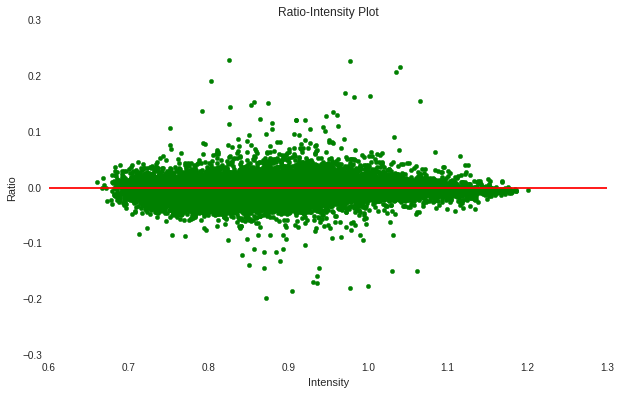

In [105]:
ratio_intensity_plot(data["C57BL/6J_Liver_CD"],data["DBA/2J_Liver_CD"])

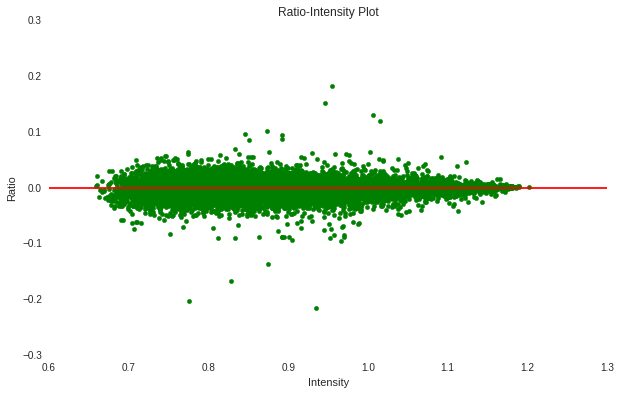

In [106]:
ratio_intensity_plot(data["BXD71_Liver_CD"],data["BXD73_Liver_CD"])

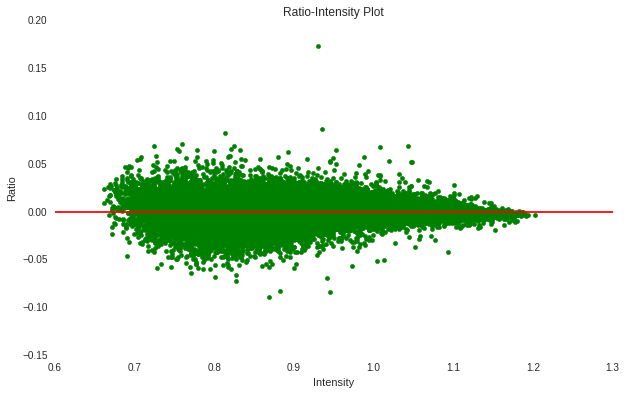

In [107]:
ratio_intensity_plot(data["BXD45_Liver_HFD"],data["BXD45_Liver_CD"])

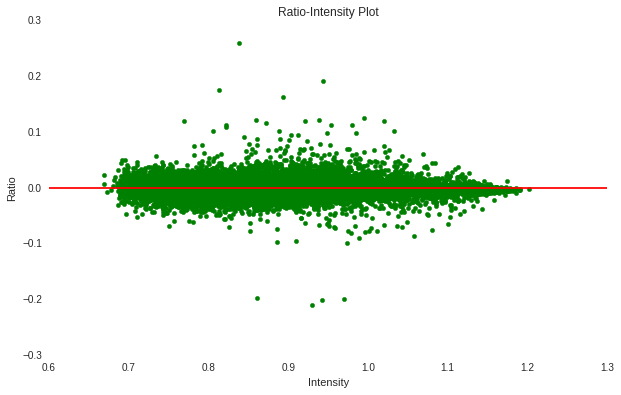

In [108]:
ratio_intensity_plot(data["BXD101_Liver_HFD"],data["BXD103_Liver_HFD"])

#### Subsubtask 1.3.3: Implement a rle plot (rle = relative log expression)

In [171]:
def rle_plot(data):
    avg = data.T/data.T.median()
    plt.figure(figsize=(16,9), dpi=80)
    plt.title("Relative log expression",fontsize=16)
    plt.xlabel("Sample",fontsize=10)
    plt.ylabel("Relative log expression",fontsize=12)
    plt.xticks(range(len(data)), data.index,
           rotation="vertical", fontsize=10)
    ax = plt.gca()
    ax.set_axis_bgcolor("white")
    sns.boxplot(data=np.log10(avg.T));

#### Subsubtask 1.3.4: Apply your RLE plot to the data

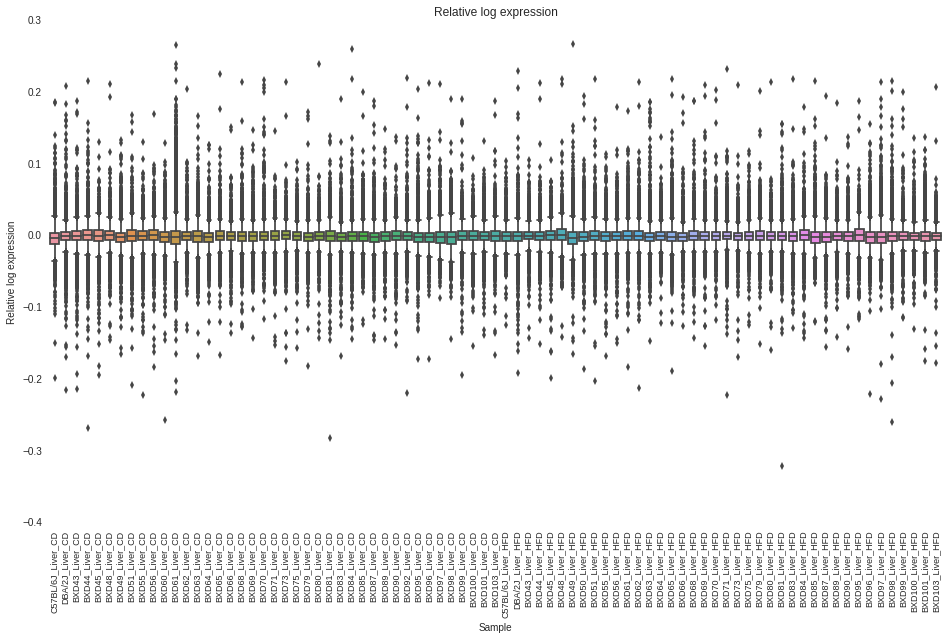

In [172]:
rle_plot(data.drop("Unnamed: 51",axis=1).ix[:,7:])

#### Subsubtask 1.3.5: If you consider it necessary, perform a quantile normalization of the data 

The ratio-intensity plots and the RLE plot show that the data are allready normalized. Hence, we continue without perform a quantile normalization. The small oscilliations of the q25 and q75 quantiles in the RLE plt can be neglected. 

## Task 2: Which statistical test to chose?

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we (mis)(?)treat (!) the (already) normalized expression values of all the strains for a given condition as independent observations of the same sample. But first we need to figure out which statistical test for differential expression seems appropriate (concerning distribution and variance assumptions) and then apply it. Limit yourself to the Student t-test, the Welch t-test or Wilcoxon's rank-sum test (also sometimes refered to as Whitney-Mann U-test).

Everything you may need, is most likely found here:

http://docs.scipy.org/doc/scipy-0.17.1/reference/stats.html 

http://statsmodels.sourceforge.net/stable/graphics.html

### Subtask 2.1: Do the CD and HFD samples have equal variance?

Josef-Francisco Del-Marre-Doyle, famous and visionary president of the International BXD Society (IBXDS), just gave a celebrated TED-talk in which he reviewed the fact that any statistic associated with the universe is almost surely normally distributed, and hence you canonically assume that the only thing left to check is whether the samples have equal variance, that is whether to apply Student's or Welch's t-test. Josef-Francisco's assessment usually is that "things are equal" and so you're quite confident that you'll be able to use Student's t-test. But since you're an excellent scientist (and, additionally, won't pass the course otherwise) you still do the following certainly unnecessary work:

#### Subsubtask 2.1.1: Choose a random row of your latest dataframe using the random module of Python

#### Subsubtask 2.1.2: Make a Q-Q plot comparing the two samples for the just chosen gene and answer the question: Does this tell you anything?

#### Subsubtask 2.1.3: Apply an appropriate statistical test in order to figure out whether the samples have equal variance (there may be more than one sensible solution)

#### Subsubtask 2.1.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.1.3)

### Subtask 2.2 Are the CD and HFD samples normally distributed?

Utterly shocked and overwhelmed by ambiguous emotions you begin to doubt the wisdom of Josef-Francisco and start a top-secret and highly dangerous investigation whether the samples are at least normally distributed. Be careful whom you'll tell about that you're working on this...

#### Subsubtask 2.2.1: Using the same gene randomly chosen above, make a Box plot for the corresponding CD and HFD sample and give an interpretation

#### Subsubtask 2.2.2: Just like in 2.2.1 make Q-Q plots for each sample (compare each to the theoretical normal distribution) and try an interpretation.

#### Subsubtask 2.2.3: Apply an appropriate statistical test in order to figure out whether the samples are normally distributed (there may be more than one sensible solution)

#### Subsubtask 2.2.4: To asses the global situation, plot a histogram of p-values for all the genes (using the same test you chose in 2.2.3)

#### Subsubtask 2.2.5: Write a 1-word essay about whether there is any instrinsic philosophical reason that any data follows a normal distribution

### Subtask 2.3 Choose a suitable statistical test to assess differential expression, apply it to every row, store the results in a suitable dataframe (you may want to order the genes with respect to their p-values) and finally extract a list of differentially expressed genes (5% significance). How many differentially expressed genes do you get?

## Task 3: Multiple-testing correction

You receive an anonymous letter revealing to you that you should do multiple-testing correction, otherwise something awfully bad will happen, or not. Puzzled and shaking you embark on this endeavour.

Fredholm, your lab's vodoo priest, is convinced that applying anything else than Bonferroni correction brings death and destruction to the people on the moon. Opportunistically neglecting any potential societal consequences of your actions (technology is neutral after all and who cares about the moon anyway!) you're obsessed to try as many multiple testing procedures as possible.

Everything you may need, is most likely found here:

http://statsmodels.sourceforge.net/stable/stats.html#multiple-tests-and-multiple-comparison-procedures

### Subtask 3.1: For your official report you have to pretend to care about Bonferroni's correction (otherwise it will never pass through Fredholm's office): manually code it (do not use the statsmodels implementation for example) and store the results in a suitable dataframe. How many differentially expressed gene do you get?

### Subtask 3.2: Apply all multiple testing procedures you can get your hands on (except Bonferroni; now you should use statsmodels) to your uncorrected p-values and store the results in one (!) dataframe. 

### Subtask 3.3: External visual comparison of the different methods
1 Write the DE dataframe to a csv file.
2 add a row with either 'numeric' or 'factor' as the first row to describe the data schema and save the file
3 use [paco](http://parallelcoordinates.de/paco) to visualize your data in parallel coordinates
4 which of the multiple testing methods is the most stringent? What's the relation between the others?

### Subtask 3.4: Select a random method applied in 3.2 and extract the corresponding list of differentially expressed genes. Is this list contain more or less genes than the list from 2.3? Does it contain more or less genes than your Bonferroni list? ;)

## Task 4: Vulcano plots

Marie de la Stratonovich, the devious intellectual opponent of your (former) beloved idol Josef-Francisco Del-Marre-Doyle just received the glorious Popel prize (the first marsian scientist ever to reveive that prize) for copy-pasting the content of the following papers:

1) arXiv:1103.3434 (https://arxiv.org/abs/1103.3434)

2) http://www.ncbi.nlm.nih.gov/pubmed/23602812 (doi:10.1016/j.compbiolchem.2013.02.003)

Overwhelmed by these achievments (and motivated by your ever declining esteem for Josef-Francisco) your're immensely excited about the joyous prospect of carrying out out the following tasks:

### Subtask 4.1: Add a log2 fold change column to the data frame from 3.2 and store it as a csv file.

### Subtask 4.2:  Implement a Vulcano plot (from scratch using matplotlib)

### Subtask 4.3: Apply your Volcano plot implementation to the uncorrected p-values, as well as the corrected p-values from 3.4 (you should have two plots in the end ;))

## Task 5: RNA-seq

There are faint rumours that some supposedly revolutionary technology could also be used to study gene expression. Find out the name of that technology and outline the most striking difference of that technology compared to microarrays from a statistical modeling point of view.